In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import numpy.ma as ma

In [3]:
import cmocean

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
projection = ccrs.Mercator(central_longitude=115.0, min_latitude=-80.0, max_latitude=84.0, latitude_true_scale=-30.0)

In [5]:
from plot_config import *

In [6]:
ecco = xr.open_zarr('/sciserver/oceanography/ECCO_v4r4/ecco_v4r4')

In [7]:
it = 229
it_begin = 225
print(ecco.time_snap[it_begin].values)
# print(ecco.time_snap[it].values)
# ecco.THETA_snap[it]

2010-11-01T00:00:00.000000000


In [8]:
tt = ecco.THETA_snap.isel(k=slice(5),face = 4).mean(dim = 'k')
tseas = tt.groupby('time_snap.month').mean('time_snap').persist()

In [38]:
particle_path = '/sciserver/filedb04-01/ocean/wenrui_temp/particle_file/WA/'
tb = xr.open_zarr(particle_path+'table1y.zarr')
sub_tb = tb.isel(space= slice(None,None,37))

In [10]:
moreseas = ecco.THETA_snap.groupby('time_snap.month').mean('time_snap')
ta = (ecco.THETA_snap.groupby('time_snap.month')-moreseas)[it]

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


In [11]:
ylim = (-35,-22.5)
xlim = (100,120)
xbool = np.logical_and(ecco.XC>xlim[0],ecco.XC<xlim[1])
ybool = np.logical_and(ecco.YC>ylim[0],ecco.YC<ylim[1])
zbool = ecco.Z>-50
pos_bool = np.logical_and(np.logical_and(xbool,ybool),zbool)
warm_bool = ta>1.5
those = np.logical_and(warm_bool,pos_bool).persist()

In [12]:
those = those.isel(face = 4).any(dim = 'k')

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


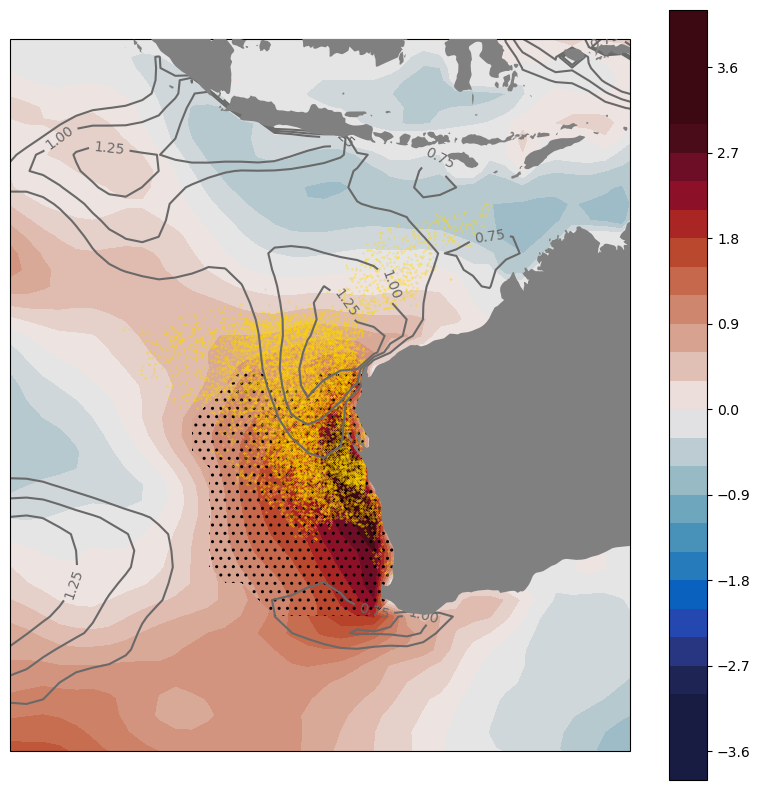

In [31]:
vmax = 3
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)

# plt.plot(sub_tb.lon,sub_tb.lat,'w',lw = 0.3,transform  = ccrs.PlateCarree())
final = np.array((tt.groupby('time_snap.month') - tseas)[it])
masked = ma.array(final,mask = those)
ct = plt.contourf(ecco.XC[4],ecco.YC[4],final,levels = 30,vmax = vmax,vmin = -vmax,cmap = cmocean.cm.balance,transform = ccrs.PlateCarree())
plt.contourf(ecco.XC[4],ecco.YC[4], np.ones_like(ecco.XC[4]),hatches = ['..',None],cmap = None,transform = ccrs.PlateCarree(),alpha = 0)
plt.contourf(ecco.XC[4],ecco.YC[4],masked,levels = 30,vmax = vmax,vmin = -vmax,cmap = cmocean.cm.balance,transform = ccrs.PlateCarree())
plt.plot(tb.lon[120],tb.lat[120],'o',c = 'gold',markersize = 0.25,transform  = ccrs.PlateCarree())
# plt.plot(tb.lon[-1],tb.lat[-1],'o',c = 'red',markersize = 0.25,transform  = ccrs.PlateCarree())
ctt = plt.contour(ecco.XC[4],ecco.YC[4],(tt.groupby('time_snap.month') - tseas)[it_begin],levels = [-20]+[0.75,1,1.25],colors = 'dimgrey',transform = ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor = 'grey',zorder = 10)
ax.set_extent([92.5,130,-40,-2.5])
plt.colorbar(ct)
plt.clabel(ctt)
plt.savefig('figure3(a)'+format)

In [20]:
past_year = slice(218,230)

In [21]:
ssh = ecco.ETAN.isel(face = 4)
sshmean = ssh.mean(dim = 'time').persist()
thisssh = ssh[past_year].mean(dim = 'time').persist()
sshplot = np.array(thisssh - sshmean)
sshplot[sshplot==0] = np.nan

In [22]:
ttt = ecco.THETA.isel(face = 4,k = 0)
tttmean = ttt.mean(dim = 'time').persist()
# thisttt = ttt[past_year].mean(dim = 'time').persist()
tttplot = np.array(tttmean)
tttplot[tttplot==0] = np.nan

In [25]:
to_fit = (slice(20,70),slice(32,None))

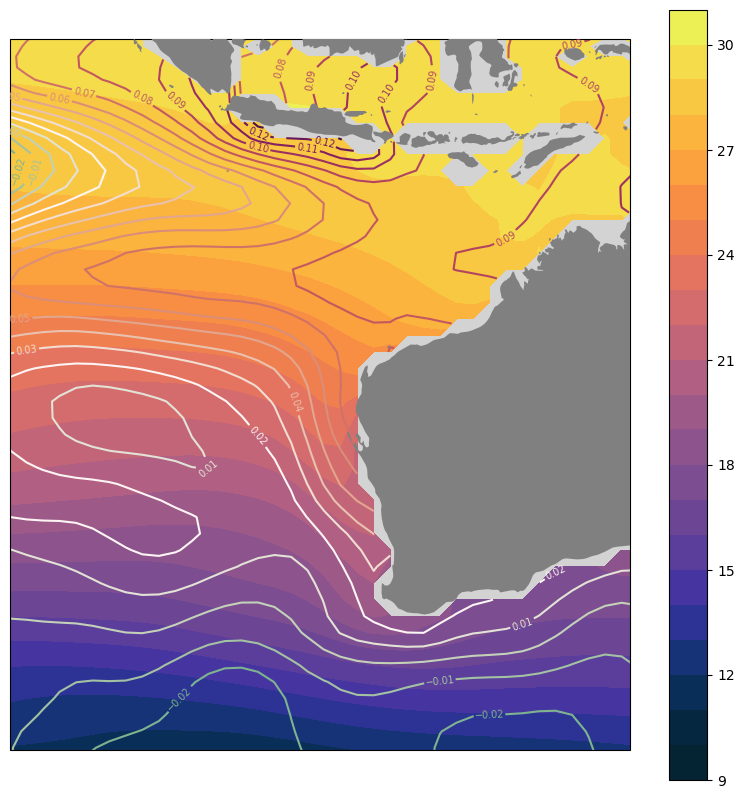

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_facecolor('lightgrey')
ct = plt.contourf(ecco.XC[4][to_fit],ecco.YC[4][to_fit],tttplot[to_fit],cmap = cmocean.cm.thermal,vmin = 10,levels = 23,transform = ccrs.PlateCarree())
ctt = plt.contour(ecco.XC[4][to_fit],ecco.YC[4][to_fit],sshplot[to_fit],cmap = cmocean.cm.curl,levels = 23,transform = ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor = 'grey',zorder = 10)
ax.set_extent([92.5,130,-40,-2.5])
plt.clabel(ctt,fontsize  =7)
plt.colorbar(ct)
plt.savefig('figure3(b)'+format)

In [33]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

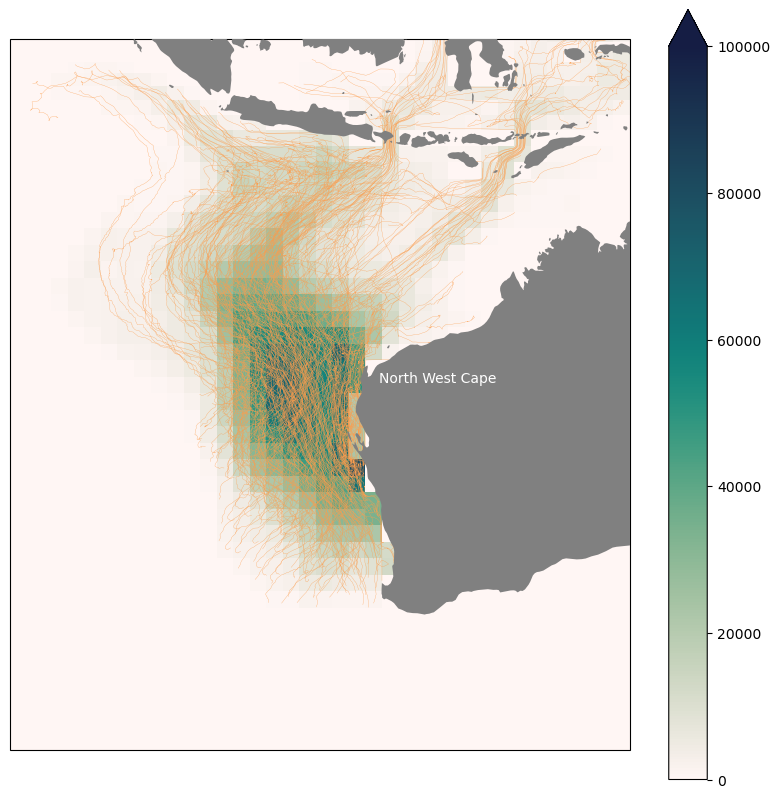

In [56]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
wau_path = '/sciserver/filedb04-01/ocean/wenrui_temp/particle_file/WA/'
map_path = wau_path+ 'map1y.zarr'
maps = xr.open_zarr(map_path)
to_plot = maps['count'].sum(dim = 'Z')
i = 4
p3 = ax.pcolormesh(xg[i] ,yg[i] ,to_plot[i] ,vmax = 1e5,vmin = 0,cmap = cmocean.cm.tempo, transform = ccrs.PlateCarree())
plt.plot(sub_tb.lon,sub_tb.lat,'#FC9E4F',lw = 0.2,transform  = ccrs.PlateCarree())
plt.text(114.8,-22.8,'North West Cape',transform = ccrs.PlateCarree(),zorder = 10,c = 'w')
ax.add_feature(cfeature.LAND, zorder=9, facecolor='grey')
# ax.set_title('Particle Days')
ax.set_extent([92.5,130,-40,-2.5])
plt.colorbar(p3,extend = 'max')
plt.savefig('figure3(c)'+format)